In [83]:
import os
import math
import glob
import wfdb
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial

from scipy import signal
from skorch import NeuralNetRegressor
from torch.utils.data import Dataset, DataLoader
from skimage.restoration import denoise_wavelet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [84]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random.seed(1658497162847124986)

data_directory = "./data/CEBS/m001"
model_directory = './models/'
sampling_rate = '10L' # 10ms https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
target_snr_dbs =        [0,1,2,3,4,5,6,10]
target_snr_weights =    (10, 10, 10)

segment_size = '10240L'
segment_size_seconds = int(pd.to_timedelta(segment_size).total_seconds())
segment_size_samples = int(pd.to_timedelta(segment_size).total_seconds() / pd.to_timedelta(sampling_rate).total_seconds())

#num_epochs = 1024
#batch_size = 64
#learning_rate = 0.001
#weight_decay = 0.01

In [85]:
def mse(signal_clean, signal_noisy):
    return mean_squared_error(signal_clean, signal_noisy)

def mae(signal_clean, signal_noisy):
    return mean_absolute_error(signal_clean, signal_noisy)

def rmse(signal_clean, signal_noisy):
    return np.sqrt(mse(signal_clean, signal_noisy))

def snr(signal_clean, signal_noisy):
    return 10 * np.log10(np.sum(signal_clean ** 2) / (np.sum((signal_noisy - signal_clean) ** 2)))

def psnr(signal_clean, signal_noisy):
    return 20 * np.log10(np.max(signal_clean) / (np.sum((signal_noisy - signal_clean) ** 2)))

def prd(signal_clean, signal_noisy):
    return np.sqrt(np.sum((signal_noisy - signal_clean) ** 2) / np.sum(signal_clean ** 2)) * 100

def xcorr(signal_clean, signal_noisy):
    return np.correlate(signal_clean, signal_noisy, mode='same')

In [86]:
def load_cebs(directory):
    record = wfdb.rdsamp(directory)
    data = record[0]
    metadata = record[1]

    frequency = metadata['fs']
    column_names = metadata['sig_name']
    length = metadata['sig_len']

    data = pd.DataFrame(data, columns=column_names)
    data.drop(['I', 'II', 'RESP'], axis=1, inplace=True)

    frequency_string = str(int(1/frequency*1000000)) + 'U'
    index = pd.date_range(start='1/1/1970', periods=length, freq=frequency_string)
    data.set_index(index, inplace=True)
    data = data.resample(sampling_rate).mean().SCG

    data = data.groupby((data.index - data.index[0]).total_seconds() * 1e3 // (segment_size_samples * 10)).agg(list)
    data = data[data.apply(lambda x: len(x) == segment_size_samples)]
    data = data.apply(lambda x: np.array(x))
    
    return data


def load_d2(directory):

    data = pd.read_csv(directory, 
                        sep=',', 
                        header=1, 
                        skiprows=[2],
                        usecols=['Shimmer_D0CD_Timestamp_Shimmer_CAL','Shimmer_D0CD_Accel_LN_Z_CAL'], 
                        dtype={'Shimmer_D0CD_Timestamp_Shimmer_CAL': 'float', 'Shimmer_D0CD_Accel_LN_Z_CAL': 'float'})
    
    data.rename(columns={'Shimmer_D0CD_Timestamp_Shimmer_CAL': 'index', 'Shimmer_D0CD_Accel_LN_Z_CAL': 'SCG'}, inplace=True)

    data['index'] = pd.to_datetime(data['index'], unit='ms')
    data.set_index('index', inplace=True)

    data = data.resample(sampling_rate).mean().SCG

    data = data.groupby((data.index - data.index[0]).total_seconds() * 1e3 // (segment_size_samples * 10)).agg(list)
    data = data[data.apply(lambda x: len(x) == segment_size_samples)]
    data = data.apply(lambda x: np.array(x))

    return data

In [91]:
def load_datasets(directory, datasets):

    data = pd.DataFrame()

    if 'CEBS' in datasets:
        filenames = list(dict.fromkeys([x[:-4] for x in glob.glob(r'./data/CEBS/*m[0-9][0-9][0-9].*')]))
        data = pd.concat((load_cebs(filename) for filename in filenames), ignore_index=True)
    if 'D2' in datasets:
        filenames =  glob.glob(r'./data/D2/CP-*')
        data2 = pd.concat((load_d2(filename) for filename in filenames), ignore_index=True)
        data = pd.concat((data, data2))

    return data

In [88]:
# https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python

def add_gaussian(data, target_snr_dbs):

    # target_snr_db = random.choices(target_snr_dbs, weights=target_snr_weights, k=1)[0]
    # target_snr_db = random.choice(target_snr_dbs)
    target_snr_db = random.uniform(0, 20) # sample from bigger range provides better results?
    # target_snr_db = 1

    data_watts = data ** 2
    data_avg_watts = np.mean(data_watts)
    data_avg_db = 10 * np.log10(data_avg_watts)

    noise_avg_db = data_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)

    mean_noise = 0
    noise = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(data_watts))

    data_noisy = data + noise
    return data_noisy

def normalize(clean, noise):
    x_concat = np.concatenate((clean, noise))
    min_val = np.min(x_concat)
    max_val = np.max(x_concat)
    y_clean = (clean-min_val) / (max_val - min_val)
    y_noise = (noise-min_val) / (max_val - min_val)
    return y_clean, y_noise, min_val, max_val

# SCG dependent on absolute values
def denormalize(clean, noise, min_val, max_val):
    y_clean = max_val * clean - clean * min_val + min_val
    y_noise = max_val * noise - noise * min_val + min_val
    return y_clean, y_noise


def bandpass(input_signal):
    # https://www.youtube.com/watch?v=juYqcck_GfU
    fs = 100.0 # frequency space
    lowcut = 5.0 # Hz
    highcut = 30.0 # Hz

    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    order = 4

    b, a, = signal.butter(order, [low, high], 'bandpass', analog=False)
    y = signal.filtfilt(b, a, input_signal, axis=0)

    return y

In [92]:
class SCGData(Dataset):

    def __init__(self, transform=None):

        self.min_val = 0
        self.max_val = np.inf

        data = load_datasets('./data/CEBS/', ['D2'])
        #data = data.resample(sampling_rate).mean().SCG

        # data = data.apply(lambda x: bandpass(x))
        data_noise = data.apply(lambda x: add_gaussian(x, target_snr_dbs))
        data = pd.DataFrame({'clean': data, 'noise': data_noise})

        #data_concat = np.concatenate([np.concatenate(data.values[0]), np.concatenate(data.values[1])])
        # https://www.geeksforgeeks.org/data-normalization-with-pandas/
        # self.min_val = np.min(data.values.tolist())
        # self.max_val = np.max(data.values.tolist())

        #data = data.apply(lambda x: normalize(x, self.min_val, self.max_val), axis=1)            
        #data = data.groupby((data.index - data.index[0]).total_seconds() * 1e3 // (segment_size_samples * 10)).agg(list)
        #data = data[data['clean'].apply(lambda x: len(x) == segment_size_samples)]
        #data['clean'] = data['clean'].apply(lambda x: np.array(x))
        #data['noise'] = data['noise'].apply(lambda x: np.array(x))
        
        self.x_data = data.noise.values
        self.y_data = data.clean.values

        self.transform = transform
        self.n_samples = data.shape[0]

    def __getitem__(self, index):
        sample = self.x_data[index].copy(), self.y_data[index].copy()

        if self.transform:
            sample = self.transform(sample)
        
        return sample
    
    def __len__(self):
        return self.n_samples


class ToTensor:
    def __call__(self, sample):
        inputs, targets = sample
        return torch.Tensor(inputs), torch.Tensor(targets)

In [93]:
def reverse2(x, min_val, max_val):
    return max_val * x - x * min_val + min_val

dataset = SCGData(transform=ToTensor())

In [ ]:
def load_data():
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    return torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:
class DeNoise1(nn.Module):
    def __init__(self, layer_size=128):
        super(DeNoise1, self).__init__()

        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p

        self.encoder = nn.Sequential(
            nn.Conv1d(1, layer_size, 3, stride=1),
            nn.BatchNorm1d(layer_size),
            nn.ELU(),
            nn.Conv1d(layer_size, int(layer_size/4), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/4), int(layer_size/8), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/8)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/8), int(layer_size/16), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/16)),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(int(layer_size/16), int(layer_size/16), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/16)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/16), int(layer_size/8), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/8)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/8), int(layer_size/4), 3, stride=1),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/4), int(layer_size), 3, stride=1), 
            nn.BatchNorm1d(int(layer_size)),
            nn.ELU(),
            nn.Conv1d(int(layer_size), 1, 3, stride=1, padding='same'),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        #encoded = encoded.view(-1, 1, segment_size_samples//8)
        #encoded = nn.functional.pad(encoded, (0, 0, 0, 0))
        decoded = self.decoder(encoded)
        return decoded

print(segment_size_samples/2 + 7)
print(segment_size_samples/(2*8) + 7)
torchinfo.summary(DeNoise1(), (32, 1, segment_size_samples), col_names=('input_size', 'output_size'))

519.0
71.0


Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise1                                 [32, 1, 1024]             [32, 1, 1024]
├─Sequential: 1-1                        [32, 1, 1024]             [32, 8, 1016]
│    └─Conv1d: 2-1                       [32, 1, 1024]             [32, 128, 1022]
│    └─BatchNorm1d: 2-2                  [32, 128, 1022]           [32, 128, 1022]
│    └─ELU: 2-3                          [32, 128, 1022]           [32, 128, 1022]
│    └─Conv1d: 2-4                       [32, 128, 1022]           [32, 32, 1020]
│    └─BatchNorm1d: 2-5                  [32, 32, 1020]            [32, 32, 1020]
│    └─ELU: 2-6                          [32, 32, 1020]            [32, 32, 1020]
│    └─Conv1d: 2-7                       [32, 32, 1020]            [32, 16, 1018]
│    └─BatchNorm1d: 2-8                  [32, 16, 1018]            [32, 16, 1018]
│    └─ELU: 2-9                          [32, 16, 1018]            [32, 16, 1018]
│    └─Conv1d: 2-

In [ ]:
class DeNoise2(nn.Module):
    def __init__(self, layer_size=128):
        super(DeNoise2, self).__init__()

        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p

        self.encoder = nn.Sequential(
            nn.Conv1d(1, layer_size, 15, stride=1),
            nn.BatchNorm1d(layer_size),
            nn.ELU(),
            nn.Conv1d(layer_size, int(layer_size/2), 15, stride=1),
            nn.BatchNorm1d(int(layer_size/2)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/2), int(layer_size/4), 15, stride=1),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.Conv1d(int(layer_size/4), 1, 15, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, int(layer_size/4), 15, stride=1),
            nn.BatchNorm1d(int(layer_size/4)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/4), int(layer_size/2), 15, stride=1),
            nn.BatchNorm1d(int(layer_size/2)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size/2), int(layer_size), 15, stride=1),
            nn.BatchNorm1d(int(layer_size)),
            nn.ELU(),
            nn.ConvTranspose1d(int(layer_size), 1, 15, stride=1), 
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.Conv1d(1, 1, 15, stride=1, padding='same'),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        #encoded = encoded.view(-1, 1, segment_size_samples//8)
        #encoded = nn.functional.pad(encoded, (0, 0, 0, 0))
        decoded = self.decoder(encoded)
        return decoded

print(segment_size_samples/2 + 7)
print(segment_size_samples/(2*8) + 7)
torchinfo.summary(DeNoise2(), (32, 1, segment_size_samples), col_names=('input_size', 'output_size'))

519.0
71.0


Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise2                                 [32, 1, 1024]             [32, 1, 1024]
├─Sequential: 1-1                        [32, 1, 1024]             [32, 1, 968]
│    └─Conv1d: 2-1                       [32, 1, 1024]             [32, 128, 1010]
│    └─BatchNorm1d: 2-2                  [32, 128, 1010]           [32, 128, 1010]
│    └─ELU: 2-3                          [32, 128, 1010]           [32, 128, 1010]
│    └─Conv1d: 2-4                       [32, 128, 1010]           [32, 64, 996]
│    └─BatchNorm1d: 2-5                  [32, 64, 996]             [32, 64, 996]
│    └─ELU: 2-6                          [32, 64, 996]             [32, 64, 996]
│    └─Conv1d: 2-7                       [32, 64, 996]             [32, 32, 982]
│    └─BatchNorm1d: 2-8                  [32, 32, 982]             [32, 32, 982]
│    └─ELU: 2-9                          [32, 32, 982]             [32, 32, 982]
│    └─Conv1d: 2-10     

In [ ]:
class DeNoiseNone(nn.Module):
    def __init__(self, kernel_size=16, filters_1=64, filters_2=32):
        super(DeNoise2, self).__init__()
        #self.p1 = segment_size_samples/2 + 7
        #self.p2 = segment_size_samples/64 + 7
        # (i-k +2*p)/s+1
        # (i-1)*s+k-2p

        self.kernel_size = kernel_size
        self.filters_1 = filters_1
        self.filters_2 = filters_2

        self.encoder = nn.Sequential(
            nn.Conv1d(1, filters_1, kernel_size, stride=2),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, filters_2, kernel_size, stride=2),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_2, kernel_size, stride=2),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_2, kernel_size, stride=2),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.Conv1d(filters_2, filters_1, kernel_size, stride=2),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, 1, kernel_size, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(1, 1, kernel_size, stride=1),
            nn.BatchNorm1d(1),
            nn.ELU(),
            nn.ConvTranspose1d(1, filters_1, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.ConvTranspose1d(filters_1, filters_2, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_2, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_2, kernel_size, stride=2, output_padding=0),
            nn.BatchNorm1d(filters_2),
            nn.ELU(),
            nn.ConvTranspose1d(filters_2, filters_1, kernel_size, stride=2, output_padding=1),
            nn.BatchNorm1d(filters_1),
            nn.ELU(),
            nn.Conv1d(filters_1, 1, kernel_size, stride=1),
            # nn.Sigmoid()
        )

    def forward(self, x):
        # x = x.view(-1, 1, segment_size_samples)
        encoded = self.encoder(x)
        #encoded = encoded.view(-1, 1, segment_size_samples//16, 1)
        #encoded = nn.functional.pad(encoded, (0, 0, 1, 0))
        decoded = self.decoder(encoded)
        return decoded


print(segment_size_samples/2 + 7)
print(segment_size_samples/(2*16) + 7)
torchinfo.summary(DeNoise2(), (32, 1, segment_size_samples), col_names=('input_size', 'output_size'))

519.0
39.0


Layer (type:depth-idx)                   Input Shape               Output Shape
DeNoise2                                 [32, 1, 1024]             [32, 1, 1024]
├─Sequential: 1-1                        [32, 1, 1024]             [32, 1, 968]
│    └─Conv1d: 2-1                       [32, 1, 1024]             [32, 128, 1010]
│    └─BatchNorm1d: 2-2                  [32, 128, 1010]           [32, 128, 1010]
│    └─ELU: 2-3                          [32, 128, 1010]           [32, 128, 1010]
│    └─Conv1d: 2-4                       [32, 128, 1010]           [32, 64, 996]
│    └─BatchNorm1d: 2-5                  [32, 64, 996]             [32, 64, 996]
│    └─ELU: 2-6                          [32, 64, 996]             [32, 64, 996]
│    └─Conv1d: 2-7                       [32, 64, 996]             [32, 32, 982]
│    └─BatchNorm1d: 2-8                  [32, 32, 982]             [32, 32, 982]
│    └─ELU: 2-9                          [32, 32, 982]             [32, 32, 982]
│    └─Conv1d: 2-10     

In [ ]:
num_epochs = 10000
train_dataset, test_dataset = load_data()

In [ ]:
def train(config, train_dataset, model_num, is_tune=False, checkpoint_dir=None, data_dir=None):

    if model_num in [1]:
        model = DeNoise1(layer_size=config['layer_size'])
    elif model_num in [2, 3]:
        model = DeNoise2(layer_size=config['layer_size'])
    model = model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['wd'])

    if checkpoint_dir != None:
        model_state, optimizer_state = torch.load(os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    test_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - test_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [test_size, val_size])

    train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=val_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)

    n_total_steps = len(train_loader)
    min_val_loss = np.inf

    train_loss_values = []
    val_loss_values = []
    epoch_values = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        epoch_steps = 0
        for i, (inputs, lables) in enumerate(train_loader):
            
            lables, inputs, _, _ = normalize(lables, inputs)

            if model_num == 3:
                inputs = denoise_wavelet(inputs, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
                
            # inputs, lables = torch.from_numpy(inputs), torch.from_numpy(lables)
            inputs, lables = inputs.view(-1, 1, segment_size_samples), lables.view(-1, 1, segment_size_samples)
            inputs, lables = inputs.to(device), lables.to(device)

            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, lables)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            epoch_steps += 1

        train_loss_values.append(train_loss)

        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, (inputs, lables) in enumerate(val_loader):

            lables, inputs, _, _ = normalize(lables, inputs)

            if model_num == 3:
                inputs = denoise_wavelet(inputs, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')

            # inputs, lables = torch.from_numpy(inputs), torch.from_numpy(lables)
            inputs, lables = inputs.view(-1, 1, segment_size_samples), lables.view(-1, 1, segment_size_samples)
            inputs, lables = inputs.to(device), lables.to(device)

            output = model(inputs)
            loss = criterion(output, lables)
            val_loss += loss.item()
            val_steps += 1
            
        val_loss_values.append(val_loss)
        epoch_values.append(epoch)

        if is_tune:
            with tune.checkpoint_dir(epoch) as checkpoint_dir:
                path = os.path.join(checkpoint_dir, 'checkpoint')
                torch.save((model.state_dict(), optimizer.state_dict()), path)
            
            tune.report(loss=(val_loss / val_steps))
        else:
            print(f'epoch {epoch + 1} / {num_epochs}, train loss = {(train_loss / len(train_loader)):.10f}, val loss = {(val_loss / len(val_loader)):.10f}')
            if min_val_loss > val_loss:
                print(f'\tval loss decreased from {min_val_loss:.10f} to {val_loss:.10f}')
                min_val_loss = val_loss

                if model_num == 1:
                    torch.save(model.state_dict(), os.path.join(model_directory, 'model_1.pth'))
                    df = pd.DataFrame({'epoch': epoch_values,'train_loss': train_loss_values, 'val_loss': val_loss_values})
                    df.to_csv('./models/loss_1.csv') 
                elif model_num == 2:
                    torch.save(model.state_dict(), os.path.join(model_directory, 'model_2.pth'))
                    df = pd.DataFrame({'epoch': epoch_values,'train_loss': train_loss_values, 'val_loss': val_loss_values})
                    df.to_csv('./models/loss_2.csv')
                elif model_num == 3:
                    torch.save(model.state_dict(), os.path.join(model_directory, 'model_3.pth'))
                    df = pd.DataFrame({'epoch': epoch_values,'train_loss': train_loss_values, 'val_loss': val_loss_values})
                    df.to_csv('./models/loss_3.csv')  

In [ ]:
# https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html

num_samples = 64 # sample data multiple times
max_num_epochs = 128

config = {
    'lr': tune.loguniform(1e-5, 1e-1),
    'wd': 0,
    'batch_size': tune.choice([8, 16, 32]),
    'layer_size': tune.choice([128])
}

scheduler = ASHAScheduler(metric='loss', mode='min', max_t=max_num_epochs, grace_period=1, reduction_factor=2)
reporter = CLIReporter(metric_columns=['loss', 'training_iteration'])
# result = tune.run(
    partial(train, train_dataset=train_dataset, model_num=2, is_tune=True, checkpoint_dir=None, data_dir=None),
    resources_per_trial={'cpu': 4, 'gpu': 1},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter
)

best_trial = result.get_best_trial('loss', 'min', 'last')
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))

best_trained_model =  DeNoise2().to(device)

best_checkpoint_dir = best_trial.checkpoint.dir_or_data
model_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, 'checkpoint'))
best_trained_model.load_state_dict(model_state)

2022-11-14 11:52:02,999	WARNING worker.py:1839 -- Warning: The actor ImplicitFunc is very large (89 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2022-11-14 11:52:03,241	WARNING util.py:244 -- The `start_trial` operation took 1.762 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 11:52:03 (running for 00:00:14.39)
Memory usage on this node: 12.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 128.000: None | Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 16/64 (15 PENDING, 1 RUNNING)
+-------------------+----------+----------------------+--------------+--------------+-------------+
| Trial name        | status   | loc                  |   batch_size |   layer_size |          lr |
|-------------------+----------+----------------------+--------------+--------------+-------------|
| train_56e46_00000 | RUNNING  | 192.168.178.25:42898 |           16 |          128 | 0.00257668  |
| train_56e46_00001 | PENDING  |                      |   

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_56e46_00000,2022-11-14_12-04-23,True,,a809f8836ff7489ab06f0e5f800b6149,pop-os,128,0.00183186,192.168.178.25,42898,True,736.987,5.7034,736.987,1668423863,0,,128,56e46_00000,0.00219274
train_56e46_00001,2022-11-14_12-04-34,True,,bcb858f38cc94b9dbb7faa413b1aadb6,pop-os,1,0.00411549,192.168.178.25,49962,True,7.57185,7.57185,7.57185,1668423874,0,,1,56e46_00001,0.00219679
train_56e46_00002,2022-11-14_12-04-46,True,,1e72baaa44c74b27bc262ddc0f030d71,pop-os,1,0.00579751,192.168.178.25,50042,True,7.71104,7.71104,7.71104,1668423886,0,,1,56e46_00002,0.00249648
train_56e46_00003,2022-11-14_12-04-58,True,,bc80544a62d745e3872224cf9a2901a4,pop-os,1,0.00449414,192.168.178.25,50129,True,7.59998,7.59998,7.59998,1668423898,0,,1,56e46_00003,0.00220919
train_56e46_00004,2022-11-14_12-05-09,True,,514a738da4164663a3adc96eb49b146a,pop-os,1,0.00495442,192.168.178.25,50215,True,6.12356,6.12356,6.12356,1668423909,0,,1,56e46_00004,0.00212026
train_56e46_00005,2022-11-14_12-05-19,True,,0b31a11843df4b8da138ffe5e76f9150,pop-os,1,0.016503,192.168.178.25,50309,True,5.99881,5.99881,5.99881,1668423919,0,,1,56e46_00005,0.00244999
train_56e46_00006,2022-11-14_12-05-50,True,,70025edca7d54c45b10f770ba61f50b6,pop-os,4,0.00403637,192.168.178.25,50396,True,27.4891,6.6842,27.4891,1668423950,0,,4,56e46_00006,0.00224924
train_56e46_00007,2022-11-14_12-06-06,True,,e737dcf84d9d4ccea6ee97520c1bdbe9,pop-os,2,0.00422134,192.168.178.25,50650,True,11.0872,5.10999,11.0872,1668423966,0,,2,56e46_00007,0.00205731
train_56e46_00008,2022-11-14_12-06-16,True,,57bb4ab72b93479fa274ba66cbe0407e,pop-os,1,0.00942246,192.168.178.25,50799,True,5.97279,5.97279,5.97279,1668423976,0,,1,56e46_00008,0.00199175
train_56e46_00009,2022-11-14_12-06-27,True,,70d96f877f6b4cbeaed3e2e61161c7c6,pop-os,1,0.00468531,192.168.178.25,50882,True,6.60296,6.60296,6.60296,1668423987,0,,1,56e46_00009,0.00216222


== Status ==
Current time: 2022-11-14 11:52:21 (running for 00:00:32.63)
Memory usage on this node: 13.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 128.000: None | Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.004026540438644588
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 17/64 (16 PENDING, 1 RUNNING)
+-------------------+----------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status   | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+----------+----------------------+--------------+--------------+-------------+------------+----------------------|
| train_56e46_00000 | RUNNING  | 

2022-11-14 12:04:24,353	WARNING util.py:244 -- The `start_trial` operation took 0.592 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:04:30 (running for 00:12:41.34)
Memory usage on this node: 13.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.0029693947852075355 | Iter 2.000: -0.0038426554719676615 | Iter 1.000: -0.004026540438644588
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 18/64 (16 PENDING, 1 RUNNING, 1 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+----

2022-11-14 12:04:36,335	WARNING util.py:244 -- The `start_trial` operation took 0.576 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:04:36 (running for 00:12:47.48)
Memory usage on this node: 12.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.0029693947852075355 | Iter 2.000: -0.0038426554719676615 | Iter 1.000: -0.004071014789034329
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 18/64 (15 PENDING, 1 RUNNING, 2 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+----

2022-11-14 12:04:48,355	WARNING util.py:244 -- The `start_trial` operation took 0.562 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:04:54 (running for 00:13:05.29)
Memory usage on this node: 14.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.0029693947852075355 | Iter 2.000: -0.0038426554719676615 | Iter 1.000: -0.00411548913942407
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 20/64 (16 PENDING, 1 RUNNING, 3 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+-----

2022-11-14 12:05:00,515	WARNING util.py:244 -- The `start_trial` operation took 0.720 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:05:00 (running for 00:13:11.65)
Memory usage on this node: 12.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.0029693947852075355 | Iter 2.000: -0.0038426554719676615 | Iter 1.000: -0.004304816715075108
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 20/64 (15 PENDING, 1 RUNNING, 4 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+----

2022-11-14 12:05:10,325	WARNING util.py:244 -- The `start_trial` operation took 0.528 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:05:16 (running for 00:13:27.26)
Memory usage on this node: 14.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.0029693947852075355 | Iter 2.000: -0.0038426554719676615 | Iter 1.000: -0.004494144290726146
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 22/64 (16 PENDING, 1 RUNNING, 5 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+----

2022-11-14 12:05:20,335	WARNING util.py:244 -- The `start_trial` operation took 0.538 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:05:26 (running for 00:13:37.25)
Memory usage on this node: 14.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.0029693947852075355 | Iter 2.000: -0.0038426554719676615 | Iter 1.000: -0.00472428341288988
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 23/64 (16 PENDING, 1 RUNNING, 6 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+-----

2022-11-14 12:05:52,363	WARNING util.py:244 -- The `start_trial` operation took 0.561 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:05:58 (running for 00:14:09.53)
Memory usage on this node: 14.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.0035028811245636574 | Iter 2.000: -0.0037924868355020307 | Iter 1.000: -0.004494144290726146
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 24/64 (16 PENDING, 1 RUNNING, 7 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+----

2022-11-14 12:06:07,341	WARNING util.py:244 -- The `start_trial` operation took 0.537 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:06:13 (running for 00:14:24.27)
Memory usage on this node: 14.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.0035028811245636574 | Iter 2.000: -0.0038426554719676615 | Iter 1.000: -0.004304816715075108
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 25/64 (16 PENDING, 1 RUNNING, 8 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+----

2022-11-14 12:06:17,330	WARNING util.py:244 -- The `start_trial` operation took 0.525 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:06:23 (running for 00:14:34.33)
Memory usage on this node: 13.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.0035028811245636574 | Iter 2.000: -0.0038426554719676615 | Iter 1.000: -0.004494144290726146
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 26/64 (16 PENDING, 1 RUNNING, 9 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+----

2022-11-14 12:06:28,358	WARNING util.py:244 -- The `start_trial` operation took 0.551 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:06:28 (running for 00:14:39.50)
Memory usage on this node: 12.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.0035028811245636574 | Iter 2.000: -0.0038426554719676615 | Iter 1.000: -0.0045897286961876504
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 26/64 (15 PENDING, 1 RUNNING, 10 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+-

2022-11-14 12:06:44,513	WARNING util.py:244 -- The `start_trial` operation took 0.704 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:06:50 (running for 00:15:01.47)
Memory usage on this node: 14.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.0035028811245636574 | Iter 2.000: -0.004031996266286145 | Iter 1.000: -0.004494144290726146
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 28/64 (16 PENDING, 1 RUNNING, 11 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+---

2022-11-14 12:06:56,352	WARNING util.py:244 -- The `start_trial` operation took 0.541 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:06:56 (running for 00:15:07.49)
Memory usage on this node: 12.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.0035028811245636574 | Iter 2.000: -0.004031996266286145 | Iter 1.000: -0.004578686808742097
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 28/64 (15 PENDING, 1 RUNNING, 12 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+---

2022-11-14 12:07:08,357	WARNING util.py:244 -- The `start_trial` operation took 0.544 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:07:14 (running for 00:15:25.29)
Memory usage on this node: 14.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.0035028811245636574 | Iter 2.000: -0.004031996266286145 | Iter 1.000: -0.004663229326758048
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 30/64 (16 PENDING, 1 RUNNING, 13 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+---

2022-11-14 12:07:18,349	WARNING util.py:244 -- The `start_trial` operation took 0.536 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:07:24 (running for 00:15:35.45)
Memory usage on this node: 14.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.0035028811245636574 | Iter 2.000: -0.004031996266286145 | Iter 1.000: -0.004674271214203602
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 31/64 (16 PENDING, 1 RUNNING, 14 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+---

2022-11-14 12:07:28,345	WARNING util.py:244 -- The `start_trial` operation took 0.530 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:07:34 (running for 00:15:45.31)
Memory usage on this node: 14.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.0035028811245636574 | Iter 2.000: -0.004031996266286145 | Iter 1.000: -0.004685313101649156
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 32/64 (16 PENDING, 1 RUNNING, 15 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+---

2022-11-14 12:07:43,339	WARNING util.py:244 -- The `start_trial` operation took 0.522 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:07:49 (running for 00:16:00.25)
Memory usage on this node: 14.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.0035028811245636574 | Iter 2.000: -0.00422133706060463 | Iter 1.000: -0.004674271214203602
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 33/64 (16 PENDING, 1 RUNNING, 16 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+----

2022-11-14 12:07:54,359	WARNING util.py:244 -- The `start_trial` operation took 0.541 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:07:54 (running for 00:16:05.50)
Memory usage on this node: 12.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.0035028811245636574 | Iter 2.000: -0.00422133706060463 | Iter 1.000: -0.004685313101649156
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 33/64 (15 PENDING, 1 RUNNING, 17 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+----

2022-11-14 12:08:12,343	WARNING util.py:244 -- The `start_trial` operation took 0.522 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:08:18 (running for 00:16:29.28)
Memory usage on this node: 14.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=18
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.0035028811245636574 | Iter 2.000: -0.00430262624020821 | Iter 1.000: -0.004674271214203602
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 35/64 (16 PENDING, 1 RUNNING, 18 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+----

2022-11-14 12:08:40,375	WARNING util.py:244 -- The `start_trial` operation took 0.550 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:08:46 (running for 00:16:57.31)
Memory usage on this node: 14.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.004036367463919779 | Iter 2.000: -0.00422133706060463 | Iter 1.000: -0.004663229326758048
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 36/64 (16 PENDING, 1 RUNNING, 19 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+-----

2022-11-14 12:08:51,370	WARNING util.py:244 -- The `start_trial` operation took 0.544 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:08:51 (running for 00:17:02.51)
Memory usage on this node: 12.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=20
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.004036367463919779 | Iter 2.000: -0.00422133706060463 | Iter 1.000: -0.004674271214203602
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 36/64 (15 PENDING, 1 RUNNING, 20 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+-----

2022-11-14 12:09:01,578	WARNING util.py:244 -- The `start_trial` operation took 0.714 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:09:07 (running for 00:17:18.52)
Memory usage on this node: 14.0/15.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.004036367463919779 | Iter 2.000: -0.00422133706060463 | Iter 1.000: -0.004685313101649156
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 38/64 (16 PENDING, 1 RUNNING, 21 TERMINATED)
+-------------------+------------+--

2022-11-14 12:10:00,407	WARNING util.py:244 -- The `start_trial` operation took 0.532 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:10:06 (running for 00:18:17.41)
Memory usage on this node: 14.0/15.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.003617615282159952 | Iter 4.000: -0.003997092614578002 | Iter 2.000: -0.004031996266286145 | Iter 1.000: -0.004674271214203602
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 39/64 (16 PENDING, 1 RUNNING, 22 TERMINATED)
+-------------------+------------+--

2022-11-14 12:10:11,435	WARNING util.py:244 -- The `start_trial` operation took 0.559 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:10:11 (running for 00:18:22.58)
Memory usage on this node: 12.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.003617615282159952 | Iter 4.000: -0.003997092614578002 | Iter 2.000: -0.004031996266286145 | Iter 1.000: -0.004685313101649156
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 39/64 (15 PENDING, 1 RUNNING, 23 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+-----

2022-11-14 12:10:21,414	WARNING util.py:244 -- The `start_trial` operation took 0.537 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:10:27 (running for 00:18:38.52)
Memory usage on this node: 14.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=24
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.003617615282159952 | Iter 4.000: -0.003997092614578002 | Iter 2.000: -0.004031996266286145 | Iter 1.000: -0.0047091942748199375
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 41/64 (16 PENDING, 1 RUNNING, 24 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+----

2022-11-14 12:10:32,457	WARNING util.py:244 -- The `start_trial` operation took 0.578 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:10:32 (running for 00:18:43.60)
Memory usage on this node: 12.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=25
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.003617615282159952 | Iter 4.000: -0.003997092614578002 | Iter 2.000: -0.004031996266286145 | Iter 1.000: -0.00473307544799072
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 41/64 (15 PENDING, 1 RUNNING, 25 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+------

2022-11-14 12:10:51,412	WARNING util.py:244 -- The `start_trial` operation took 0.531 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:10:57 (running for 00:19:08.40)
Memory usage on this node: 14.0/15.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.003617615282159952 | Iter 4.000: -0.003997092614578002 | Iter 2.000: -0.00422133706060463 | Iter 1.000: -0.0047091942748199375
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 43/64 (16 PENDING, 1 RUNNING, 26 TERMINATED)
+-------------------+------------+--

2022-11-14 12:11:02,429	WARNING util.py:244 -- The `start_trial` operation took 0.546 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:11:02 (running for 00:19:13.58)
Memory usage on this node: 12.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.003617615282159952 | Iter 4.000: -0.003997092614578002 | Iter 2.000: -0.00422133706060463 | Iter 1.000: -0.00473307544799072
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 43/64 (15 PENDING, 1 RUNNING, 27 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+-------

2022-11-14 12:11:13,638	WARNING util.py:244 -- The `start_trial` operation took 0.732 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:11:19 (running for 00:19:30.57)
Memory usage on this node: 14.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=28
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.003617615282159952 | Iter 4.000: -0.003997092614578002 | Iter 2.000: -0.00422133706060463 | Iter 1.000: -0.004819952357953799
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 45/64 (16 PENDING, 1 RUNNING, 28 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+------

2022-11-14 12:11:30,487	WARNING util.py:244 -- The `start_trial` operation took 0.554 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:11:36 (running for 00:19:47.44)
Memory usage on this node: 14.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=29
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.003617615282159952 | Iter 4.000: -0.003997092614578002 | Iter 2.000: -0.004292155354050919 | Iter 1.000: -0.00473307544799072
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 46/64 (16 PENDING, 1 RUNNING, 29 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+------

2022-11-14 12:11:42,459	WARNING util.py:244 -- The `start_trial` operation took 0.525 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:11:42 (running for 00:19:53.60)
Memory usage on this node: 12.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=30
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.003617615282159952 | Iter 4.000: -0.003997092614578002 | Iter 2.000: -0.004292155354050919 | Iter 1.000: -0.004819952357953799
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 46/64 (15 PENDING, 1 RUNNING, 30 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+-----

2022-11-14 12:11:54,632	WARNING util.py:244 -- The `start_trial` operation took 0.696 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:12:00 (running for 00:20:11.56)
Memory usage on this node: 14.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=31
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.003617615282159952 | Iter 4.000: -0.003997092614578002 | Iter 2.000: -0.004292155354050919 | Iter 1.000: -0.004906829267916879
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 48/64 (16 PENDING, 1 RUNNING, 31 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+-----

2022-11-14 12:12:06,476	WARNING util.py:244 -- The `start_trial` operation took 0.536 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:12:06 (running for 00:20:17.62)
Memory usage on this node: 12.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=32
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.003617615282159952 | Iter 4.000: -0.003997092614578002 | Iter 2.000: -0.004292155354050919 | Iter 1.000: -0.004930625901485247
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 48/64 (15 PENDING, 1 RUNNING, 32 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+-----

2022-11-14 12:12:25,485	WARNING util.py:244 -- The `start_trial` operation took 0.542 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:12:31 (running for 00:20:42.41)
Memory usage on this node: 14.0/15.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=33
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.003617615282159952 | Iter 4.000: -0.003997092614578002 | Iter 2.000: -0.004362973647497209 | Iter 1.000: -0.004906829267916879
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 50/64 (16 PENDING, 1 RUNNING, 33 TERMINATED)
+-------------------+------------+--

2022-11-14 12:13:16,490	WARNING util.py:244 -- The `start_trial` operation took 0.541 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:13:22 (running for 00:21:33.62)
Memory usage on this node: 14.1/15.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=34
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0036372845577400015 | Iter 4.000: -0.003957817765236225 | Iter 2.000: -0.004292155354050919 | Iter 1.000: -0.004819952357953799
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 51/64 (16 PENDING, 1 RUNNING, 34 TERMINATED)
+-------------------+------------+-

2022-11-14 12:13:28,504	WARNING util.py:244 -- The `start_trial` operation took 0.553 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:13:28 (running for 00:21:39.66)
Memory usage on this node: 12.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=35
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0036372845577400015 | Iter 4.000: -0.003957817765236225 | Iter 2.000: -0.004292155354050919 | Iter 1.000: -0.004906829267916879
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 51/64 (15 PENDING, 1 RUNNING, 35 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+----

2022-11-14 12:14:27,495	WARNING util.py:244 -- The `start_trial` operation took 0.538 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:14:33 (running for 00:22:44.50)
Memory usage on this node: 14.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=36
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0036753360650937086 | Iter 4.000: -0.0038729721480352886 | Iter 2.000: -0.00422133706060463 | Iter 1.000: -0.004819952357953799
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 53/64 (16 PENDING, 1 RUNNING, 36 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+----

2022-11-14 12:14:59,508	WARNING util.py:244 -- The `start_trial` operation took 0.546 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:15:05 (running for 00:23:16.45)
Memory usage on this node: 14.0/15.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=37
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0036753360650937086 | Iter 4.000: -0.003946993603249607 | Iter 2.000: -0.004150837138881614 | Iter 1.000: -0.00473307544799072
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 54/64 (16 PENDING, 1 RUNNING, 37 TERMINATED)
+-------------------+------------+--

2022-11-14 12:15:11,502	WARNING util.py:244 -- The `start_trial` operation took 0.538 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:15:11 (running for 00:23:22.64)
Memory usage on this node: 12.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=38
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0018410394851375244 | Iter 8.000: -0.0036753360650937086 | Iter 4.000: -0.003946993603249607 | Iter 2.000: -0.004150837138881614 | Iter 1.000: -0.004819952357953799
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 54/64 (15 PENDING, 1 RUNNING, 38 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+----

2022-11-14 12:16:38,687	WARNING util.py:244 -- The `start_trial` operation took 0.713 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:16:44 (running for 00:24:55.62)
Memory usage on this node: 14.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=39
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0026930223945688843 | Iter 8.000: -0.0036372845577400015 | Iter 4.000: -0.0038675600670419795 | Iter 2.000: -0.004080337217158597 | Iter 1.000: -0.00473307544799072
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 56/64 (16 PENDING, 1 RUNNING, 39 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+----

2022-11-14 12:16:55,545	WARNING util.py:244 -- The `start_trial` operation took 0.562 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:17:01 (running for 00:25:12.48)
Memory usage on this node: 14.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=40
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0026930223945688843 | Iter 8.000: -0.0036372845577400015 | Iter 4.000: -0.0038675600670419795 | Iter 2.000: -0.004150837138881614 | Iter 1.000: -0.0047091942748199375
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 57/64 (16 PENDING, 1 RUNNING, 40 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+--

2022-11-14 12:17:07,508	WARNING util.py:244 -- The `start_trial` operation took 0.523 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:17:07 (running for 00:25:18.65)
Memory usage on this node: 12.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=41
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0026930223945688843 | Iter 8.000: -0.0036372845577400015 | Iter 4.000: -0.0038675600670419795 | Iter 2.000: -0.004150837138881614 | Iter 1.000: -0.00473307544799072
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 57/64 (15 PENDING, 1 RUNNING, 41 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+----

2022-11-14 12:17:58,544	WARNING util.py:244 -- The `start_trial` operation took 0.552 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:18:04 (running for 00:26:15.66)
Memory usage on this node: 14.0/15.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=42
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0026930223945688843 | Iter 8.000: -0.0036753360650937086 | Iter 4.000: -0.0037881265308343523 | Iter 2.000: -0.004080337217158597 | Iter 1.000: -0.0047091942748199375
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 59/64 (16 PENDING, 1 RUNNING, 42 TERMINATED)
+-------------------+------------

2022-11-14 12:18:08,527	WARNING util.py:244 -- The `start_trial` operation took 0.535 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:18:14 (running for 00:26:25.47)
Memory usage on this node: 14.0/15.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=43
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0026930223945688843 | Iter 8.000: -0.0036753360650937086 | Iter 4.000: -0.0037881265308343523 | Iter 2.000: -0.004080337217158597 | Iter 1.000: -0.00473307544799072
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 60/64 (16 PENDING, 1 RUNNING, 43 TERMINATED)
+-------------------+------------+-

2022-11-14 12:18:18,510	WARNING util.py:244 -- The `start_trial` operation took 0.516 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:18:24 (running for 00:26:35.47)
Memory usage on this node: 14.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=44
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0026930223945688843 | Iter 8.000: -0.0036753360650937086 | Iter 4.000: -0.0037881265308343523 | Iter 2.000: -0.004080337217158597 | Iter 1.000: -0.004819952357953799
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 61/64 (16 PENDING, 1 RUNNING, 44 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+---

2022-11-14 12:18:29,543	WARNING util.py:244 -- The `start_trial` operation took 0.547 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:18:29 (running for 00:26:40.68)
Memory usage on this node: 12.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=45
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0026930223945688843 | Iter 8.000: -0.0036753360650937086 | Iter 4.000: -0.0037881265308343523 | Iter 2.000: -0.004080337217158597 | Iter 1.000: -0.004906829267916879
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 61/64 (15 PENDING, 1 RUNNING, 45 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+---

2022-11-14 12:19:28,787	WARNING util.py:244 -- The `start_trial` operation took 0.751 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:19:34 (running for 00:27:45.78)
Memory usage on this node: 14.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=46
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0026930223945688843 | Iter 8.000: -0.003713387572447416 | Iter 4.000: -0.0037648086899223373 | Iter 2.000: -0.004063674093871985 | Iter 1.000: -0.004819952357953799
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 63/64 (16 PENDING, 1 RUNNING, 46 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+----

2022-11-14 12:19:40,602	WARNING util.py:244 -- The `start_trial` operation took 0.564 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:19:40 (running for 00:27:51.74)
Memory usage on this node: 12.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=47
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0026930223945688843 | Iter 8.000: -0.003713387572447416 | Iter 4.000: -0.0037648086899223373 | Iter 2.000: -0.004063674093871985 | Iter 1.000: -0.004906829267916879
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 63/64 (15 PENDING, 1 RUNNING, 47 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+----

2022-11-14 12:21:07,611	WARNING util.py:244 -- The `start_trial` operation took 0.563 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:21:12 (running for 00:29:23.76)
Memory usage on this node: 14.0/15.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=48
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.003118162406688749 | Iter 8.000: -0.0036753360650937086 | Iter 4.000: -0.003741490849010322 | Iter 2.000: -0.004047010970585372 | Iter 1.000: -0.004819952357953799
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 64/64 (15 PENDING, 1 RUNNING, 48 TERMINATED)
+-------------------+------------+--

2022-11-14 12:22:44,617	WARNING util.py:244 -- The `start_trial` operation took 0.556 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:22:49 (running for 00:31:00.76)
Memory usage on this node: 14.0/15.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=49
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0033315838553444966 | Iter 8.000: -0.0036372845577400015 | Iter 4.000: -0.0036806860773426564 | Iter 2.000: -0.003944833221276516 | Iter 1.000: -0.00473307544799072
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 64/64 (14 PENDING, 1 RUNNING, 49 TERMINATED)
+-------------------+------------+-

2022-11-14 12:22:54,594	WARNING util.py:244 -- The `start_trial` operation took 0.532 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:22:59 (running for 00:31:10.74)
Memory usage on this node: 14.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=50
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0033315838553444966 | Iter 8.000: -0.0036372845577400015 | Iter 4.000: -0.0036806860773426564 | Iter 2.000: -0.003944833221276516 | Iter 1.000: -0.004819952357953799
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 64/64 (13 PENDING, 1 RUNNING, 50 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+---

2022-11-14 12:23:04,787	WARNING util.py:244 -- The `start_trial` operation took 0.722 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:23:04 (running for 00:31:15.95)
Memory usage on this node: 12.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=51
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0033315838553444966 | Iter 8.000: -0.0036372845577400015 | Iter 4.000: -0.0036806860773426564 | Iter 2.000: -0.003944833221276516 | Iter 1.000: -0.004906829267916879
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 64/64 (12 PENDING, 1 RUNNING, 51 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+---

2022-11-14 12:23:15,612	WARNING util.py:244 -- The `start_trial` operation took 0.548 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:23:20 (running for 00:31:31.76)
Memory usage on this node: 14.0/15.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=52
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0033315838553444966 | Iter 8.000: -0.0036372845577400015 | Iter 4.000: -0.0036806860773426564 | Iter 2.000: -0.003944833221276516 | Iter 1.000: -0.004930625901485247
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 64/64 (11 PENDING, 1 RUNNING, 52 TERMINATED)
+-------------------+------------+

2022-11-14 12:23:25,601	WARNING util.py:244 -- The `start_trial` operation took 0.536 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:23:30 (running for 00:31:41.75)
Memory usage on this node: 14.1/15.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=53
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0033315838553444966 | Iter 8.000: -0.0036372845577400015 | Iter 4.000: -0.0036806860773426564 | Iter 2.000: -0.003944833221276516 | Iter 1.000: -0.004954422535053615
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 64/64 (10 PENDING, 1 RUNNING, 53 TERMINATED)
+-------------------+------------+

2022-11-14 12:23:53,619	WARNING util.py:244 -- The `start_trial` operation took 0.550 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:23:58 (running for 00:32:09.76)
Memory usage on this node: 14.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=54
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0033315838553444966 | Iter 8.000: -0.0036372845577400015 | Iter 4.000: -0.003741490849010322 | Iter 2.000: -0.0038426554719676615 | Iter 1.000: -0.004930625901485247
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 64/64 (9 PENDING, 1 RUNNING, 54 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+----

2022-11-14 12:24:03,612	WARNING util.py:244 -- The `start_trial` operation took 0.543 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:24:08 (running for 00:32:19.75)
Memory usage on this node: 14.1/15.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=55
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0033315838553444966 | Iter 8.000: -0.0036372845577400015 | Iter 4.000: -0.003741490849010322 | Iter 2.000: -0.0038426554719676615 | Iter 1.000: -0.004954422535053615
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 64/64 (8 PENDING, 1 RUNNING, 55 TERMINATED)
+-------------------+------------+-

2022-11-14 12:24:14,620	WARNING util.py:244 -- The `start_trial` operation took 0.549 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:24:14 (running for 00:32:25.76)
Memory usage on this node: 12.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=56
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0033315838553444966 | Iter 8.000: -0.0036372845577400015 | Iter 4.000: -0.003741490849010322 | Iter 2.000: -0.0038426554719676615 | Iter 1.000: -0.004981402189047055
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 64/64 (7 PENDING, 1 RUNNING, 56 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+----

2022-11-14 12:24:32,596	WARNING util.py:244 -- The `start_trial` operation took 0.524 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:24:37 (running for 00:32:48.75)
Memory usage on this node: 14.1/15.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=57
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0033315838553444966 | Iter 8.000: -0.0036372845577400015 | Iter 4.000: -0.003741490849010322 | Iter 2.000: -0.003944833221276516 | Iter 1.000: -0.004954422535053615
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 64/64 (6 PENDING, 1 RUNNING, 57 TERMINATED)
+-------------------+------------+--

2022-11-14 12:24:43,603	WARNING util.py:244 -- The `start_trial` operation took 0.529 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:24:43 (running for 00:32:54.74)
Memory usage on this node: 12.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=58
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0033315838553444966 | Iter 8.000: -0.0036372845577400015 | Iter 4.000: -0.003741490849010322 | Iter 2.000: -0.003944833221276516 | Iter 1.000: -0.004981402189047055
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 64/64 (5 PENDING, 1 RUNNING, 58 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+-----

2022-11-14 12:24:54,628	WARNING util.py:244 -- The `start_trial` operation took 0.554 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:24:59 (running for 00:33:10.77)
Memory usage on this node: 14.1/15.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=59
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.0033315838553444966 | Iter 8.000: -0.0036372845577400015 | Iter 4.000: -0.003741490849010322 | Iter 2.000: -0.003944833221276516 | Iter 1.000: -0.005008381843040495
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 64/64 (4 PENDING, 1 RUNNING, 59 TERMINATED)
+-------------------+------------+--

2022-11-14 12:26:30,601	WARNING util.py:244 -- The `start_trial` operation took 0.519 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:26:35 (running for 00:34:46.76)
Memory usage on this node: 14.1/15.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=60
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0021008942155809752 | Iter 16.000: -0.003545005304000244 | Iter 8.000: -0.003617615282159952 | Iter 4.000: -0.0036806860773426564 | Iter 2.000: -0.0038426554719676615 | Iter 1.000: -0.004981402189047055
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 64/64 (3 PENDING, 1 RUNNING, 60 TERMINATED)
+-------------------+------------+--

2022-11-14 12:29:18,800	WARNING util.py:244 -- The `start_trial` operation took 0.708 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:29:23 (running for 00:37:34.95)
Memory usage on this node: 14.0/15.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=61
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0023085594855666415 | Iter 16.000: -0.0033315838553444966 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.0036198813056749902 | Iter 2.000: -0.0038090145063851477 | Iter 1.000: -0.004954422535053615
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 64/64 (2 PENDING, 1 RUNNING, 61 TERMINATED)
+-------------------+------------+

2022-11-14 12:29:30,666	WARNING util.py:244 -- The `start_trial` operation took 0.574 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:29:35 (running for 00:37:46.81)
Memory usage on this node: 14.1/15.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=62
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0023085594855666415 | Iter 16.000: -0.0033315838553444966 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.0036198813056749902 | Iter 2.000: -0.0038090145063851477 | Iter 1.000: -0.004981402189047055
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 64/64 (1 PENDING, 1 RUNNING, 62 TERMINATED)
+-------------------+------------+

2022-11-14 12:29:42,686	WARNING util.py:244 -- The `start_trial` operation took 0.593 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-11-14 12:29:47 (running for 00:37:58.83)
Memory usage on this node: 14.0/15.6 GiB : ***LOW MEMORY*** less than 10% of the memory on this node is available for use. This can cause unexpected crashes. Consider reducing the memory used by your application or reducing the Ray object store size by setting `object_store_memory` when calling `ray.init`.
Using AsyncHyperBand: num_stopped=63
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0023085594855666415 | Iter 16.000: -0.0033315838553444966 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.0036198813056749902 | Iter 2.000: -0.0038090145063851477 | Iter 1.000: -0.005008381843040495
Resources requested: 4.0/8 CPUs, 1.0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 64/64 (1 RUNNING, 63 TERMINATED)
+-------------------+------------+-----------

2022-11-14 12:29:51,679	INFO tune.py:777 -- Total run time: 2284.03 seconds (2282.68 seconds for the tuning loop).


== Status ==
Current time: 2022-11-14 12:29:51 (running for 00:38:02.69)
Memory usage on this node: 13.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=64
Bracket: Iter 128.000: -0.0018318614236014928 | Iter 64.000: -0.0018246276836023376 | Iter 32.000: -0.0023085594855666415 | Iter 16.000: -0.0033315838553444966 | Iter 8.000: -0.0035979460065799027 | Iter 4.000: -0.0036198813056749902 | Iter 2.000: -0.0038090145063851477 | Iter 1.000: -0.005115947634508105
Resources requested: 0/8 CPUs, 0/1 GPUs, 0.0/3.21 GiB heap, 0.0/1.61 GiB objects (0.0/1.0 accelerator_type:G)
Result logdir: /home/jonas/ray_results/train_2022-11-14_11-51-48
Number of trials: 64/64 (64 TERMINATED)
+-------------------+------------+----------------------+--------------+--------------+-------------+------------+----------------------+
| Trial name        | status     | loc                  |   batch_size |   layer_size |          lr |       loss |   training_iteration |
|-------------------+------------+----------------

<All keys matched successfully>

In [ ]:
# {'lr': 0.0006948120282769452, 'wd': 0, 'batch_size': 16, 'layer_size': 128} 0.0013009571703150868

# {'lr': 0.0025766834278764987, 'wd': 0, 'batch_size': 16, 'layer_size': 128} 0.0018318614236014928

# train({'lr': 0.0007, 'wd': 0, 'layer_size': 128, 'batch_size': 16}, train_dataset, 1)
train({'lr': 0.0025, 'wd': 0, 'layer_size': 128, 'batch_size': 16}, train_dataset, 2)
# train({'lr': 0.0005, 'wd': 0, 'layer_size': 128, 'batch_size': 8}, train_dataset, 3)

epoch 1 / 10000, train loss = 0.0057314805, val loss = 0.0037379616
	val loss decreased from inf to 0.2168017743
epoch 2 / 10000, train loss = 0.0048225674, val loss = 0.0036753345
	val loss decreased from 0.2168017743 to 0.2131694005
epoch 3 / 10000, train loss = 0.0049654605, val loss = 0.0041573891
epoch 4 / 10000, train loss = 0.0050090776, val loss = 0.0038933442
epoch 5 / 10000, train loss = 0.0053732643, val loss = 0.0036290854
	val loss decreased from 0.2131694005 to 0.2104869544
epoch 6 / 10000, train loss = 0.0047649841, val loss = 0.0029416445
	val loss decreased from 0.2104869544 to 0.1706153812
epoch 7 / 10000, train loss = 0.0049935155, val loss = 0.0033347667
epoch 8 / 10000, train loss = 0.0045369791, val loss = 0.0034379133
epoch 9 / 10000, train loss = 0.0048019366, val loss = 0.0036124069
epoch 10 / 10000, train loss = 0.0046315636, val loss = 0.0029211508
	val loss decreased from 0.1706153812 to 0.1694267459
epoch 11 / 10000, train loss = 0.0046584417, val loss = 0.

KeyboardInterrupt: 

In [ ]:
def plot_result_bar(data, labels, xlabel, ylabel, title):
    plt.xticks(range(len(data[0])), labels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    width = 0.1

    for i in range(len(target_snr_dbs) + 1):
        plt.bar(np.arange(len(data[i])) + i * width, data[i], width=width)
    plt.legend(target_snr_dbs + ['all'])
    plt.show()

def save_results(results):

    if not os.path.exists('./results'):
        os.mkdir('./results')

    # run_name = str(len(os.listdir('./results')))
    # working_dir = os.path.join('./results', run_name)
    # working_dir = os.mkdir(working_dir)

    working_dir = os.path.join('./results', '0')

    # SNR imp
    data = [[np.mean(results[method][scope]['snr_imp']) for method in results.keys()] for scope in target_snr_dbs + ['all']]
    plot_result_bar(data, results.keys(), 'Denoising Method', 'SNR Improvement (dB)', 'Mean SNR Improvement')

    # MSE
    data = [[np.mean(results[method][scope]['mse']) for method in results.keys()] for scope in target_snr_dbs + ['all']]
    plot_result_bar(data, results.keys(), 'Denoising Method', 'MSE', 'Mean MSE')

    # RMSE
    data = [[np.mean(results[method][scope]['rmse']) for method in results.keys()] for scope in target_snr_dbs + ['all']]
    plot_result_bar(data, results.keys(), 'Denoising Method', 'RMSE', 'Mean RMSE')

    # MAE
    data = [[np.mean(results[method][scope]['mae']) for method in results.keys()] for scope in target_snr_dbs + ['all']]
    plot_result_bar(data, results.keys(), 'Denoising Method', 'MAE', 'Mean MAE')

    # PSNR
    data = [[np.mean(results[method][scope]['psnr']) for method in results.keys()] for scope in target_snr_dbs + ['all']]
    plot_result_bar(data, results.keys(), 'Denoising Method', 'PSNR', 'Mean PSNR')

    # xcorr

    # PRD
    data = [[np.mean(results[method][scope]['prd']) for method in results.keys()] for scope in target_snr_dbs + ['all']]
    plot_result_bar(data, results.keys(), 'Denoising Method', 'PRD', 'Mean PRD')


    # CPU Consumption
    data = [np.mean(results[method]['all']['cpu_time']) * 1000 for method in results.keys()]

    labels = results.keys()
    plt.xticks(range(len(data)), labels)
    plt.xlabel('Denoising Method')
    plt.ylabel('CPU Time (ms)')
    plt.title('Mean CPU Time')

    plt.bar(np.arange(len(data)), data)
    plt.show()

1850
*** AE1 ***
47
SNR IMP 1.734845323210701
RMSE 2.0594554
PRD 78.86073462506558
CPU TIME 0.0014876150424900883

1850
*** WD ***
47
SNR IMP 2.248817325985812
RMSE 1.9176195
PRD 73.72520109440418
CPU TIME 0.0006094125318223304

1850
*** AE2 ***
47
SNR IMP 1.442634225129447
RMSE 2.251489
PRD 85.35255637574703
CPU TIME 0.0013808820425223762



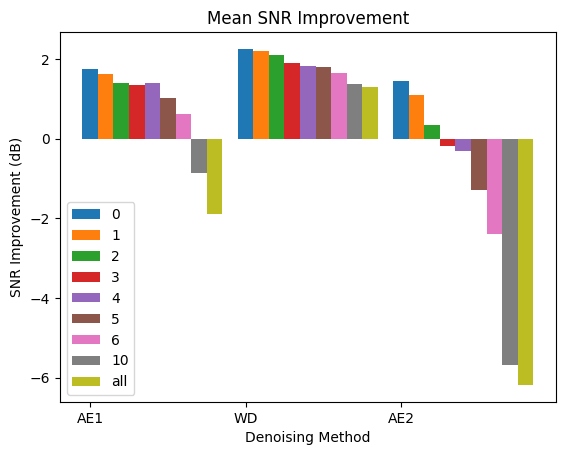

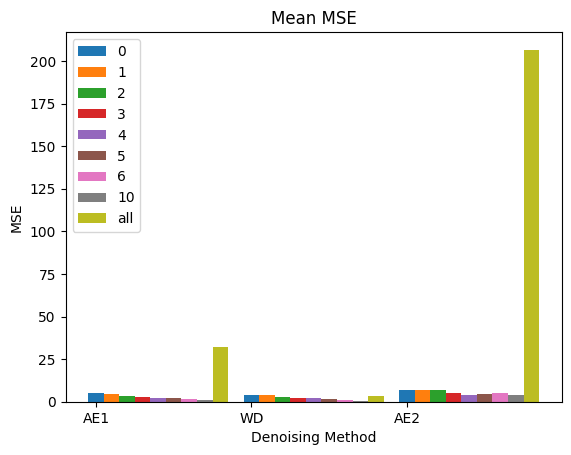

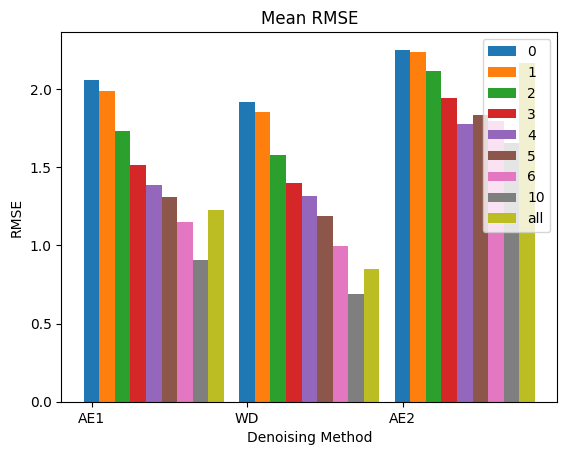

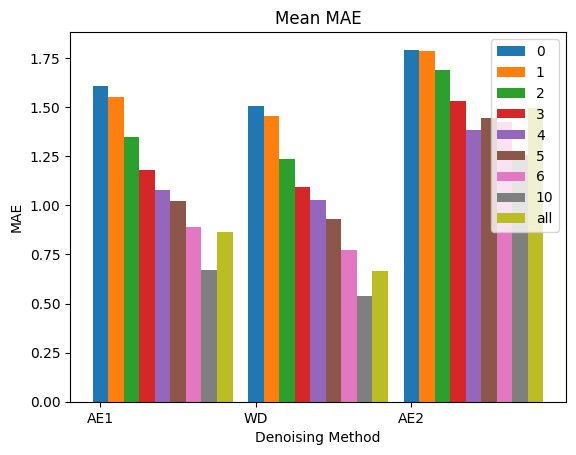

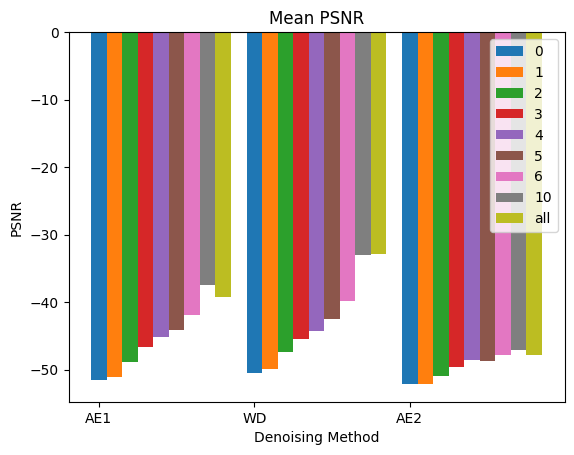

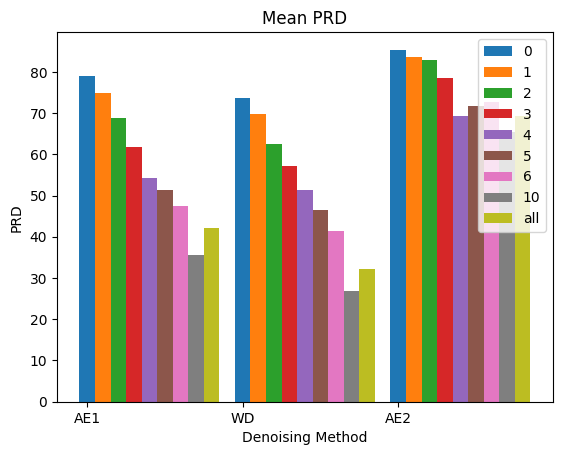

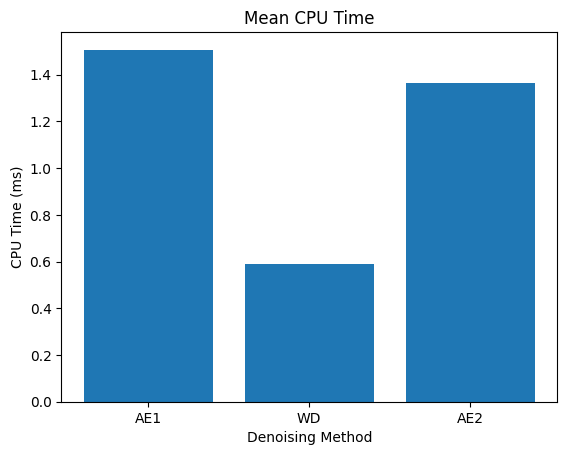

In [ ]:
def reverse(x):
    return dataset.max_val * x - x * dataset.min_val + dataset.min_val

def test(config):
    
    with torch.no_grad():

        ae1 = DeNoise1(layer_size=128).to(device)
        ae1.load_state_dict(torch.load(os.path.join(model_directory, 'model_1.pth')))
        ae1.eval()

        ae2 = DeNoise2(layer_size=128).to(device)
        ae2.load_state_dict(torch.load(os.path.join(model_directory, 'model_2.pth')))
        ae2.eval()

        ae3 = DeNoise2(layer_size=128).to(device)
        # ae3.load_state_dict(torch.load(os.path.join(model_directory, 'model_3.pth')))
        ae3.eval()

        results = {}

        for method in config['methods']:
            
            results[method] = {}
            for target in target_snr_dbs + ['all']:
                results[method][target] = {
                    'result': [],
                    'snr_imp': [],
                    'mse': [],
                    'rmse': [],
                    'mae': [],
                    'psnr': [],
                    'xcorr': [],
                    'prd': [],
                    'cpu_time': []
                }
            i = 0
            for noise, clean in test_dataset:

                cpu_time = 0
                clean, noise, min_val, max_val = normalize(clean, noise)

                if method == 'AE1':
                    
                    noise = noise.reshape(-1, 1, segment_size_samples).to(device)

                    cpu_time_start = time.process_time()
                    predicted = ae1(noise)
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start

                    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
                    predicted = predicted.to('cpu').reshape(segment_size_samples).numpy()
                elif method == 'AE2':
                    noise = noise.reshape(-1, 1, segment_size_samples).to(device)

                    cpu_time_start = time.process_time()
                    predicted = ae2(noise)
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start

                    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
                    predicted = predicted.to('cpu').reshape(segment_size_samples).numpy()
                elif method == 'WD':
                    noise = noise.numpy()

                    cpu_time_start = time.process_time()
                    predicted = denoise_wavelet(noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start
                elif method == 'AE1+WD':
                    noise = noise.numpy()

                    cpu_time_start = time.process_time()
                    predicted = denoise_wavelet(noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
                    noise = torch.from_numpy(predicted)
                    noise = noise.reshape(-1, 1, segment_size_samples).to(device)
                    predicted = ae1(noise)
                    cpu_time_stop = time.process_time()
                    cpu_time = cpu_time_stop - cpu_time_start

                    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
                    predicted = predicted.to('cpu').reshape(segment_size_samples).numpy()
                else:
                    break

                clean_old = clean.numpy()
                clean, noise = denormalize(clean_old, noise, min_val, max_val)
                clean, predicted = denormalize(clean_old, predicted, min_val, max_val)
                
                #noise = reverse2(noise[20:1004], dataset.min_val, dataset.max_val)
                #predicted = reverse2(predicted[20:1004], dataset.min_val, dataset.max_val)
                #clean = reverse2(clean[20:1004], dataset.min_val, dataset.max_val)

                snr_data = snr(clean, noise)
                for target in target_snr_dbs + ['all']:
                    if (str(target) == 'all') or (snr_data > (target - 0.8) and snr_data < (target + 0.8)):
                        i += 1
                        results[method][target]['result'].append(predicted)
                        results[method][target]['snr_imp'].append([snr(clean, predicted) - snr_data])
                        results[method][target]['mse'].append([mse(clean, predicted)])
                        results[method][target]['rmse'].append([rmse(clean, predicted)])
                        results[method][target]['mae'].append([mae(clean, predicted)])
                        results[method][target]['psnr'].append([psnr(clean, predicted)])
                        # xcorr
                        results[method][target]['prd'].append([prd(clean, predicted)])
                        results[method][target]['cpu_time'].append(cpu_time)
            
            print(i)
            value = 0
            print('*** ' + method + ' ***')
            print(len(results[method][value]['result']))
            print('SNR IMP ' + str(np.mean(results[method][value]['snr_imp'])))
            print('RMSE ' + str(np.mean(results[method][value]['rmse'])))
            print('PRD ' + str(np.mean(results[method][value]['prd'])))
            print('CPU TIME ' + str(np.mean(results[method][value]['cpu_time'])))
            print()

        save_results(results)


config = {
    'methods': ['AE1', 'WD', 'AE2'] # 'AE1+WD']
}
test(config)

10.9078
6.7766943

3.0167649
1.8666723

-1.987399309873581
0.07979370653629303
0.032524256967008114

-59.170517921447754
-55.03613471984863

[-186.65842  -123.48817   -75.23184  ...  143.12366    16.020441
  -26.126019]
[-14.637066  -14.879869  -16.844486  ...  -4.2588506  -9.134271
  -9.489467 ]



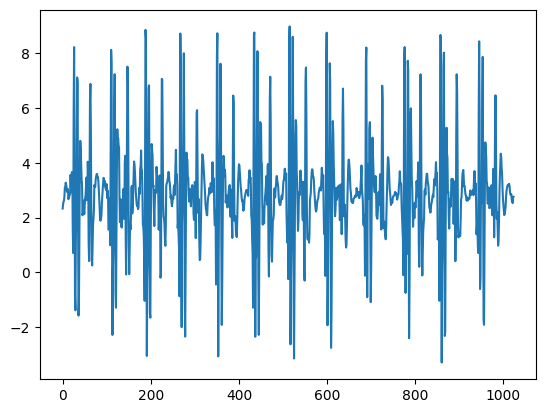

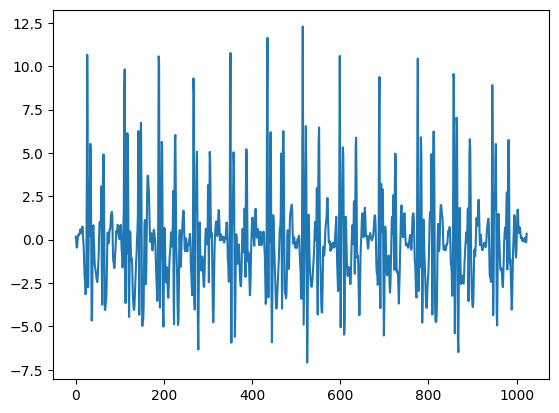

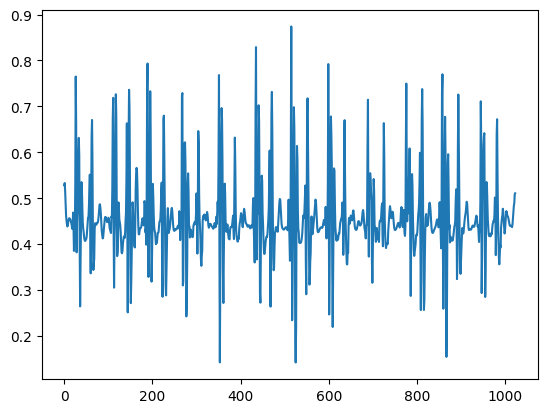

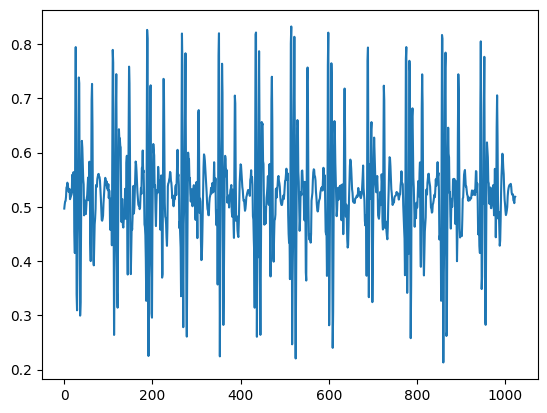

In [ ]:
model1 = DeNoise1(layer_size=128).to(device)
model1.load_state_dict(torch.load(os.path.join(model_directory, 'model_1.pth')))

model2 = DeNoise2(layer_size=128).to(device)
model2.load_state_dict(torch.load(os.path.join(model_directory, 'model_2.pth')))

model1.eval()
model2.eval()

with torch.no_grad():
    
    i = 124
    noise = test_dataset[i][0]
    clean = test_dataset[i][1]

    clean, noise, min_val, max_val = normalize(clean, noise)
    clean = clean.reshape(-1, 1, segment_size_samples).to(device)
    noise = noise.reshape(-1, 1, segment_size_samples).to(device)

    predicted = model1(noise).to('cpu').reshape(segment_size_samples).numpy()
    predicted2 = model2(noise).to('cpu').reshape(segment_size_samples).numpy()
    clean_old = clean.to('cpu').reshape(segment_size_samples).numpy()
    noise = noise.to('cpu').reshape(segment_size_samples).numpy()
    # predicted2 = denoise_wavelet(noise, method='BayesShrink', mode='soft', wavelet_levels=1, wavelet='sym8', rescale_sigma='True')
    
    clean, noise = denormalize(clean_old, noise, min_val, max_val)
    clean, noise = denormalize(clean_old, predicted, min_val, max_val)
    clean, noise = denormalize(clean_old, predicted2, min_val, max_val)

    from_val = 0
    to_val = 1024
    #noise = reverse(noise[from_val:to_val])
    #clean = reverse(clean[from_val:to_val])
    #predicted = reverse(predicted[from_val:to_val])
    #predicted2 = reverse(predicted2[from_val:to_val])

    print(mse(clean, noise))
    print(mse(clean, predicted))
    print()

    print(mae(clean, noise))
    print(mae(clean, predicted))
    print()

    print(snr(clean, noise))
    print(snr(clean, predicted))
    print(snr(clean, predicted2))
    print()

    print(psnr(clean, noise))
    print(psnr(clean, predicted))
    print()

    print(xcorr(clean, noise))
    print(xcorr(clean, predicted))
    print()
    
    time_from = 0
    time_to = 1024

    plt.plot(range(time_to)[time_from:time_to], noise[time_from:time_to])
    plt.show()
    plt.plot(range(time_to)[time_from:time_to], clean[time_from:time_to])
    plt.show()
    plt.plot(range(time_to)[time_from:time_to], predicted[time_from:time_to])
    plt.show()
    plt.plot(range(time_to)[time_from:time_to], predicted2[time_from:time_to])
    plt.show()

    torch.cuda.empty_cache()